In [2]:
#pip installs
!pip3 install -q ipython-autotime
!pip3 install h5py -q

In [3]:
%reload_ext autotime
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from itertools import islice

import gc
import h5py
from tqdm import tqdm
import librosa
import random

import warnings
warnings.filterwarnings("ignore", message="`torch.cuda.amp.autocast.*` is deprecated.*")

time: 4.57 s (started: 2024-11-24 04:12:01 +00:00)


In [4]:
class SplitDataset(Dataset):
    def __init__(self, h5_file, indices):
        self.h5_file = h5_file
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as hf:
            index = self.indices[idx]
            spectrogram = hf['spectrograms'][index] / 255.0  # Load one item and normalize
            label = hf['labels'][index]
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
            spectrogram = spectrogram.unsqueeze(0)
            label = torch.tensor(label, dtype=torch.long)

            # Call garbage collector periodically
            if idx % 1000 == 0:
                gc.collect()
            
            return spectrogram, label

time: 985 µs (started: 2024-11-24 04:12:06 +00:00)


In [5]:
def create_splits(h5_path, test_split=0.1, val_split=0.2, seed=42):
    """Create dataset splits without loading entire dataset"""
    # Get dataset size without loading data
    with h5py.File(h5_path, 'r') as f:
        total_size = len(f['spectrograms'])
        labels = f['labels'][:]

    labels = labels.argmax(axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Generate globally shuffled indices
    rng = np.random.RandomState(seed)
    all_indices = np.arange(total_size)
    rng.shuffle(all_indices)
    
    # Calculate split sizes
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - test_size - val_size
    
    # Create index lists for each split
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    
    # Create datasets using your SplitDataset class
    train_dataset = SplitDataset(h5_path, train_indices)
    val_dataset = SplitDataset(h5_path, val_indices)
    test_dataset = SplitDataset(h5_path, test_indices)
    
    return train_dataset, val_dataset, test_dataset, class_weights

time: 6.66 ms (started: 2024-11-24 04:12:06 +00:00)


In [6]:
def create_data_loaders(h5_path, batch_size=32, test_split=0.1, val_split=0.2,
                       seed=42, num_workers=4):
    """Create data loaders with memory-efficient splitting"""
    
    # Clear memory before creating splits
    gc.collect()
    torch.cuda.empty_cache()
    
    # Create datasets
    train_dataset, val_dataset, test_dataset, class_weights = create_splits(
        h5_path, test_split, val_split, seed
    )
    
    # Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle validation
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle test
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    return train_loader, val_loader, test_loader, class_weights

time: 10.7 ms (started: 2024-11-24 04:12:06 +00:00)


In [7]:
DATASET_SIZE = 105526
BATCH_SIZE = 32
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2
NUM_WORKERS = 4
H5_PATH = '/kaggle/input/raga-ieee-preprocessing/processed_spectrograms.h5'

train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        h5_path=H5_PATH,
        batch_size=BATCH_SIZE,
        test_split=TEST_SPLIT,
        val_split=VAL_SPLIT,
        num_workers=NUM_WORKERS,
        seed=420
    )

print(f"\nDataset splits:")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Val size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Dataset splits:
Train size: 73869
Val size: 21105
Test size: 10552
time: 2.08 s (started: 2024-11-24 04:12:06 +00:00)


In [8]:
# from collections import defaultdict

# def label_distribution(dataloader):
#     label_counts = defaultdict(int)
    
#     for _, labels in dataloader:
#         # Convert one-hot encoded labels to class indices
#         label_indices = labels.argmax(dim=1)  # Get the index of the 1 in each one-hot label
        
#         for label in label_indices:
#             label_counts[label.item()] += 1
    
#     # Calculate the distribution as percentages
#     total_count = sum(label_counts.values())
#     label_distribution = {label: count / total_count * 100 for label, count in label_counts.items()}
    
#     print("Label distribution (in percentages):")
#     for label, percentage in label_distribution.items():
#         print(f"Class {label}: {percentage:.2f}% ({label_counts[label]} samples)")
    
#     return label_counts


# x = label_distribution(test_loader)
# plt.bar(x.keys(),x.values())

time: 737 µs (started: 2024-11-23 16:38:40 +00:00)


In [9]:
# def plot_mel_spectrogram(mel_spectrogram, sr=16000, hop_length=512, title="Mel Spectrogram"):
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(mel_spectrogram, 
#                              sr=sr, 
#                              hop_length=hop_length, 
#                              x_axis='time', 
#                              y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

time: 7.37 ms (started: 2024-11-23 16:38:40 +00:00)


In [10]:
# # Get one random batch from the train_loader
# data_iter = iter(train_loader)
# spectrograms, labels = next(data_iter)

# # Select a random index within the batch
# random_idx = random.randint(0, spectrograms.size(0) - 1)

# # Get the spectrogram and label at that index
# spectrogram = spectrograms[random_idx].squeeze().numpy()
# label = labels[random_idx].argmax().item()  # Assuming one-hot encoded labels

# plot_mel_spectrogram(spectrogram, title=f"Mel Spectrogram for {label}")

time: 4.66 ms (started: 2024-11-23 16:38:40 +00:00)


In [11]:
# class CNNForSpectrograms(nn.Module):
#     def __init__(self):
#         super(CNNForSpectrograms, self).__init__()
        
#         # First block
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (256x256) -> (256x256)
#         self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
#         self.dropout1 = nn.Dropout(0.2)  # Dropout after first block
        
#         # Second block
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (128x128) -> (128x128)
#         self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
#         self.dropout2 = nn.Dropout(0.2)  # Dropout after second block
        
#         # Third block
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (64x64) -> (64x64)
#         self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
#         self.dropout3 = nn.Dropout(0.3)  # Dropout after third block
        
#         # Fourth block
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # (32x32) -> (32x32)
#         self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
#         self.dropout4 = nn.Dropout(0.3)  # Dropout after fourth block
        
#         # Final fully connected layer to reduce to a 16x16 feature space
#         self.fc = nn.Linear(256 * 16 * 16, 1024)  # Flattened 16x16x256 -> 1024
#         self.dropout_fc = nn.Dropout(0.4)  # Dropout before final output
        
#         # Output layer (for classification)
#         self.output = nn.Linear(1024, 10)  # For 10 thaat classes

#     def forward(self, x):
#         # Forward pass through convolutional blocks
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = self.dropout1(x)  # Apply dropout
        
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = self.dropout2(x)  # Apply dropout
        
#         x = F.relu(self.conv3(x))
#         x = self.pool3(x)
#         x = self.dropout3(x)  # Apply dropout
        
#         x = F.relu(self.conv4(x))
#         x = self.pool4(x)
#         x = self.dropout4(x)  # Apply dropout
        
#         # Flatten the output from convolutional layers
#         x = x.view(x.size(0), -1)  # Flatten: batch_size x (256*16*16)
        
#         # Fully connected layer with dropout
#         x = F.relu(self.fc(x))
#         x = self.dropout_fc(x)  # Apply dropout
        
#         # Output layer for classification
#         x = self.output(x)
        
#         return x

time: 5.16 ms (started: 2024-11-23 16:38:40 +00:00)


In [8]:
class CNN_with_BottleNeck(nn.Module):
    def __init__(self):
        super(CNN_with_BottleNeck, self).__init__()
        
        # Feature extraction blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.1)  # Dropout after conv1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(p=0.15)  # Dropout after conv2
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(p=0.15)  # Dropout after conv3
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout2d(p=0.15)  # Dropout after conv4
        
        # Additional convolutional block for better feature extraction
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)  # (16x16) -> (8x8)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout2d(p=0.2)  # Dropout after conv5
        
        # Bottleneck: Progressive channel reduction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1)
        )
        
        # Global average pooling for spatial reduction
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classification head
        self.fc = nn.Linear(1 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)  # Apply dropout after conv1
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)  # Apply dropout after conv2
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)  # Apply dropout after conv3
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)  # Apply dropout after conv4
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout5(x)  # Apply dropout after conv5
        
        x = self.bottleneck(x)  # Shape: (batch_size, 1, 8, 8)
        x = self.global_pool(x)  # Shape: (batch_size, 1, 4, 4)
        
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 16)
        x = self.fc(x)  # Shape: (batch_size, 10)
        
        return x


time: 2.16 ms (started: 2024-11-24 04:12:08 +00:00)


In [9]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []
    
    # Create progress bar for validation
    val_pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for spectrograms, labels in val_pbar:
            spectrograms = spectrograms.to(device)
            labels = torch.argmax(labels, dim=1).to(device).long()
            
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            val_pbar.set_postfix({'loss': loss.item()})
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    
    return val_loss, val_accuracy

time: 8.36 ms (started: 2024-11-24 04:12:08 +00:00)


In [10]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []
    
    # Create progress bar for testing
    test_pbar = tqdm(test_loader, desc='Testing')
    
    with torch.no_grad():
        for spectrograms, labels in test_pbar:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices
            
            test_predictions.extend(predicted.cpu().numpy())  # Convert to numpy array of class indices
            test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Convert one-hot to class indices
    
    # Convert to numpy arrays for consistency
    test_predictions = np.array(test_predictions)
    test_labels = np.array(test_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')
    
    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

time: 5.01 ms (started: 2024-11-24 04:12:08 +00:00)


In [11]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

time: 7.29 ms (started: 2024-11-24 04:12:08 +00:00)


In [12]:
def train_model(model, train_loader, val_loader, num_epochs, class_weights, device='cuda'):
    # Initialize model, loss, and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_labels = []
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for spectrograms, labels in train_pbar:
            # Move data to device
            spectrograms = spectrograms.to(device)
            labels = torch.argmax(labels, dim=1).to(device).long()
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader)
        train_accuracy = accuracy_score(train_labels, train_predictions)
        
        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),  # Save LR scheduler state
                'train_losses': train_losses,  # Training losses for all epochs
                'val_losses': val_losses,      # Validation losses for all epochs
                'train_accuracies': train_accuracies,  # Training accuracies for all epochs
                'val_accuracies': val_accuracies,      # Validation accuracies for all epochs
                'val_loss': val_loss,  # Best validation loss
            }, 'best_model_4x4_with_metrics.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= 5:  # Early stopping patience
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                break
        
        # Print epoch metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        torch.cuda.empty_cache()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

time: 2.46 ms (started: 2024-11-24 04:12:08 +00:00)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = RagaFeatureExtractorCNN(input_channels=1, num_classes=10).to(device)
model = CNN_with_BottleNeck().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

print(model)

Using 2 GPUs!
DataParallel(
  (module): CNN_with_BottleNeck(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.1, inplace=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.15, inplace=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout2d(p=0.15, inplace=False)
    (conv4): Conv2

In [15]:
history = train_model(model, 
                      train_loader,
                      val_loader,
                      num_epochs=25,
                      class_weights=class_weights.to(device),
                      device=device)

Validation: 100%|██████████| 660/660 [01:49<00:00,  6.04it/s, loss=2.18]



Epoch 1/25:
Train Loss: 2.2361, Train Accuracy: 0.1511
Val Loss: 2.0665, Val Accuracy: 0.2129


Validation: 100%|██████████| 660/660 [01:51<00:00,  5.92it/s, loss=1.83]



Epoch 2/25:
Train Loss: 1.8239, Train Accuracy: 0.3160
Val Loss: 1.4752, Val Accuracy: 0.4707


Validation: 100%|██████████| 660/660 [01:51<00:00,  5.92it/s, loss=1.09] 



Epoch 3/25:
Train Loss: 1.3326, Train Accuracy: 0.5262
Val Loss: 0.9832, Val Accuracy: 0.6557


Validation: 100%|██████████| 660/660 [01:52<00:00,  5.84it/s, loss=0.815]



Epoch 4/25:
Train Loss: 1.0437, Train Accuracy: 0.6347
Val Loss: 0.8002, Val Accuracy: 0.7284


Validation: 100%|██████████| 660/660 [01:51<00:00,  5.94it/s, loss=0.811]



Epoch 5/25:
Train Loss: 0.8844, Train Accuracy: 0.6928
Val Loss: 0.6677, Val Accuracy: 0.7731


Validation: 100%|██████████| 660/660 [01:52<00:00,  5.87it/s, loss=0.507]



Epoch 6/25:
Train Loss: 0.7863, Train Accuracy: 0.7282
Val Loss: 0.6675, Val Accuracy: 0.7828


Validation: 100%|██████████| 660/660 [01:49<00:00,  6.03it/s, loss=0.499]



Epoch 7/25:
Train Loss: 0.7184, Train Accuracy: 0.7511
Val Loss: 0.5471, Val Accuracy: 0.8162


Validation: 100%|██████████| 660/660 [01:48<00:00,  6.11it/s, loss=0.735]



Epoch 8/25:
Train Loss: 0.6645, Train Accuracy: 0.7696
Val Loss: 0.5383, Val Accuracy: 0.8191


Validation: 100%|██████████| 660/660 [01:47<00:00,  6.16it/s, loss=0.655] 



Epoch 9/25:
Train Loss: 0.6235, Train Accuracy: 0.7826
Val Loss: 0.5255, Val Accuracy: 0.8278


Validation: 100%|██████████| 660/660 [01:49<00:00,  6.03it/s, loss=0.376]



Epoch 10/25:
Train Loss: 0.5919, Train Accuracy: 0.7961
Val Loss: 0.4785, Val Accuracy: 0.8434


Validation: 100%|██████████| 660/660 [01:48<00:00,  6.07it/s, loss=0.506]



Epoch 11/25:
Train Loss: 0.5698, Train Accuracy: 0.8016
Val Loss: 0.4512, Val Accuracy: 0.8507


Validation: 100%|██████████| 660/660 [01:52<00:00,  5.89it/s, loss=0.391]



Epoch 12/25:
Train Loss: 0.5431, Train Accuracy: 0.8111
Val Loss: 0.4466, Val Accuracy: 0.8548


Validation: 100%|██████████| 660/660 [01:53<00:00,  5.84it/s, loss=0.532]



Epoch 13/25:
Train Loss: 0.5271, Train Accuracy: 0.8169
Val Loss: 0.4712, Val Accuracy: 0.8440


Validation: 100%|██████████| 660/660 [01:52<00:00,  5.86it/s, loss=0.401] 



Epoch 14/25:
Train Loss: 0.5131, Train Accuracy: 0.8214
Val Loss: 0.4165, Val Accuracy: 0.8615


Validation: 100%|██████████| 660/660 [01:53<00:00,  5.83it/s, loss=0.354] 



Epoch 15/25:
Train Loss: 0.4962, Train Accuracy: 0.8265
Val Loss: 0.4188, Val Accuracy: 0.8654


Validation: 100%|██████████| 660/660 [01:52<00:00,  5.87it/s, loss=0.343] 



Epoch 16/25:
Train Loss: 0.4806, Train Accuracy: 0.8316
Val Loss: 0.3910, Val Accuracy: 0.8681


Validation: 100%|██████████| 660/660 [01:50<00:00,  5.95it/s, loss=0.34]  



Epoch 17/25:
Train Loss: 0.4695, Train Accuracy: 0.8372
Val Loss: 0.3898, Val Accuracy: 0.8726


Validation: 100%|██████████| 660/660 [01:52<00:00,  5.87it/s, loss=0.341] 



Epoch 18/25:
Train Loss: 0.4621, Train Accuracy: 0.8413
Val Loss: 0.4136, Val Accuracy: 0.8679


Validation: 100%|██████████| 660/660 [01:54<00:00,  5.76it/s, loss=0.388] 



Epoch 19/25:
Train Loss: 0.4533, Train Accuracy: 0.8400
Val Loss: 0.3847, Val Accuracy: 0.8760


Validation: 100%|██████████| 660/660 [01:55<00:00,  5.73it/s, loss=0.199] 



Epoch 20/25:
Train Loss: 0.4468, Train Accuracy: 0.8441
Val Loss: 0.4026, Val Accuracy: 0.8730


Validation: 100%|██████████| 660/660 [01:59<00:00,  5.55it/s, loss=0.276] 



Epoch 21/25:
Train Loss: 0.4441, Train Accuracy: 0.8447
Val Loss: 0.3757, Val Accuracy: 0.8816


Validation: 100%|██████████| 660/660 [01:56<00:00,  5.66it/s, loss=0.315] 



Epoch 22/25:
Train Loss: 0.4290, Train Accuracy: 0.8493
Val Loss: 0.3638, Val Accuracy: 0.8806


Validation: 100%|██████████| 660/660 [01:59<00:00,  5.54it/s, loss=0.38]  



Epoch 23/25:
Train Loss: 0.4313, Train Accuracy: 0.8482
Val Loss: 0.3634, Val Accuracy: 0.8811


Validation: 100%|██████████| 660/660 [01:56<00:00,  5.67it/s, loss=0.21]  



Epoch 24/25:
Train Loss: 0.4227, Train Accuracy: 0.8510
Val Loss: 0.3724, Val Accuracy: 0.8811


Validation: 100%|██████████| 660/660 [01:53<00:00,  5.80it/s, loss=0.234] 


Epoch 25/25:
Train Loss: 0.4174, Train Accuracy: 0.8538
Val Loss: 0.3691, Val Accuracy: 0.8839
time: 3h 32min 29s (started: 2024-11-23 19:27:59 +00:00)


/tmp/ipykernel_30/294592279.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_4x4_with_metrics.pth')


Best Validation Loss: 0.363423051538341


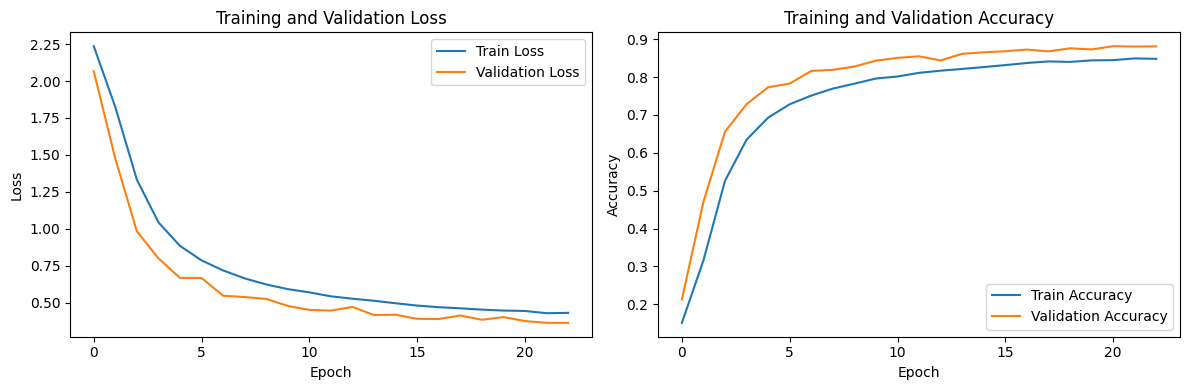

time: 557 ms (started: 2024-11-24 04:13:44 +00:00)


In [16]:
checkpoint = torch.load('best_model_4x4_with_metrics.pth')
model.load_state_dict(checkpoint['model_state_dict'])

train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
best_val_loss = checkpoint['val_loss']

# val_losses = checkpoint['val_loss']
print(f"Best Validation Loss: {best_val_loss}")

model.eval()
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [17]:
test_metrics = test_model(model, test_loader, device)

Testing: 100%|██████████| 330/330 [01:03<00:00,  5.19it/s]


Test Results:
Accuracy: 0.8787
Precision: 0.8818
Recall: 0.8787
F1 Score: 0.8792
time: 1min 3s (started: 2024-11-24 04:14:09 +00:00)
